<a href="https://colab.research.google.com/github/ElhananElboher/siren/blob/dev/Copy_of_explore_siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import glob
import random

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

<a id='section_1_1'></a>
## Fitting multiple images

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little datast that does nothing except calculating per-pixel coordinates:

2D Wrapper

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image  f(x)  with pixel coordinates  x  with a SIREN  Φ(x) .

That is we seek the function  Φ  such that:  L=∫Ω∥Φ(x)−f(x)∥dx  is minimized, in which  Ω  is the domain of the image.

We write a little datast that does nothing except calculating per-pixel coordinates:

In [4]:
class ImageFitting(Dataset):
    def __init__(self, 
                 sidelength, 
                 in_folder="/dev/ee_data_48",
                 num_samples_per_image=0,
                 idx=-1):
        self.in_folder = in_folder
        self.sidelength = sidelength
        self.num_samples_per_image = num_samples_per_image
        self.sampled_coords_inds = None
        self.sampled_pixels_inds = None
        #if self.num_samples_per_image > 0:
        #    self.sampled_coords_inds, self.sampled_pixels_inds = self.sample_coords()
        self.idx = idx
        super().__init__()
        
        self.pixels = None
        self.coords = None
        for idx, filename in enumerate(sorted(os.listdir(self.in_folder))):
            if self.idx > 0 and idx != self.idx:
                continue
            # print(f'Gathering img #{idx}')
            img = self.load_image(os.path.join(self.in_folder, filename))
            img = self.transform_image(img)
            # self.img_preloaded.append(img)
            img_pixels = img.permute(1, 2, 0).reshape(-1, 1)
            img_coords = get_mgrid(sidelength, 2)
            if self.num_samples_per_image > 0:
                sampled_coords_inds, sampled_pixels_inds = self.sample_coords()
                # img_pixels = img_pixels[self.sampled_pixels_inds]
                # img_coords = img_coords[self.sampled_coords_inds]
                img_pixels = img_pixels[sampled_pixels_inds]
                img_coords = img_coords[sampled_coords_inds]
            img_inds = torch.tensor([idx] * len(img_coords))
            img_coords = torch.hstack((img_coords, torch.unsqueeze(img_inds, 1)))
            self.pixels = img_pixels if self.pixels is None else torch.cat((self.pixels, img_pixels), 0)
            self.coords = img_coords if self.coords is None else torch.cat((self.coords, img_coords), 0)
            # print([self.pixels.shape, self.coords.shape])
        
        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        # self.coords = get_mgrid(sidelength, 2)


    def load_image(self, filename):
        img = Image.open(filename, 'r').convert('RGB')
        img = img.crop((0, 0, self.sidelength, self.sidelength))
        return img

    
    def sample_coords(self):
        sampled_coords_inds = sorted(random.sample(range(self.sidelength**2), self.num_samples_per_image))
        sampled_pixels_inds = []
        #for i in range(3):
        #    sampled_pixels_inds.extend([(x + i * self.sidelength**2) for x in sampled_coords_inds])
        for i, sc in enumerate(sampled_coords_inds):
            sampled_pixels_inds.extend([3*sc, 3*sc+1, 3*sc+2])
        # print(sampled_pixels_inds)
        # print(len(sampled_pixels_inds))
        return sampled_coords_inds, sampled_pixels_inds


    def transform_image(self, img):
        transform = Compose([
            Resize(self.sidelength),
            ToTensor(),
            Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]), torch.Tensor([0.5]))
            ])
        t_img = transform(img)
        return t_img


    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

Generalizaion wrapper

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [ ]:
img_dataset = ImageFitting(48)
dataloader = DataLoader(img_dataset, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

training loop

Step 0, Total loss 0.802872


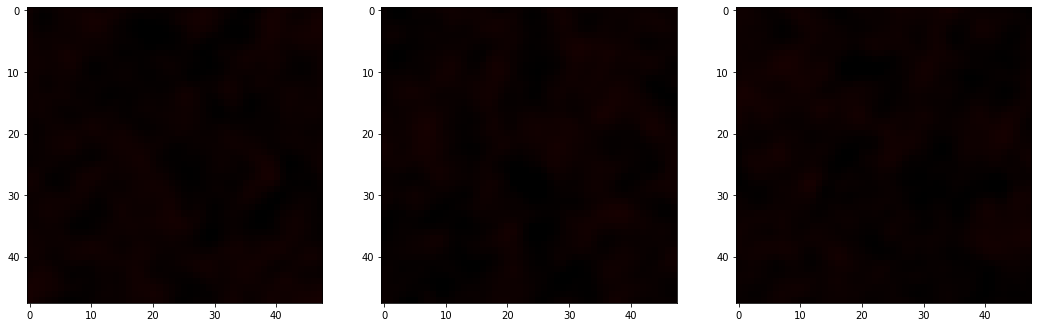

Step 50, Total loss 0.182227


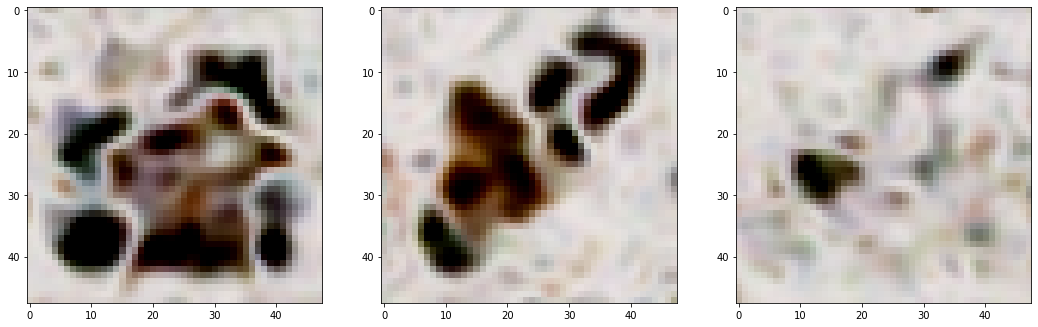

Step 100, Total loss 0.073563


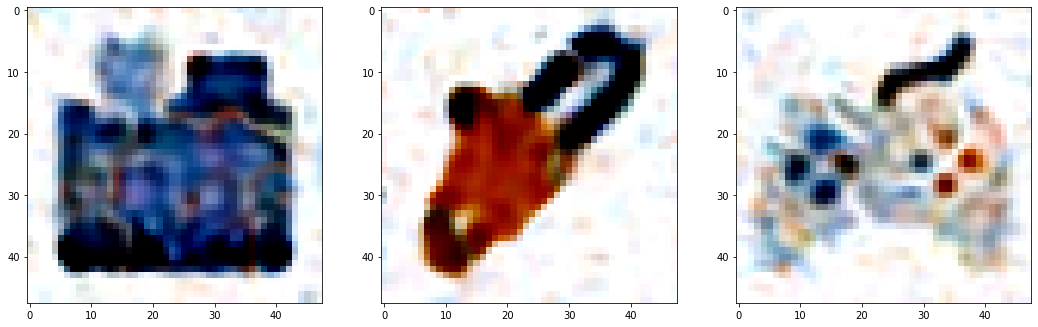

Step 150, Total loss 0.034697


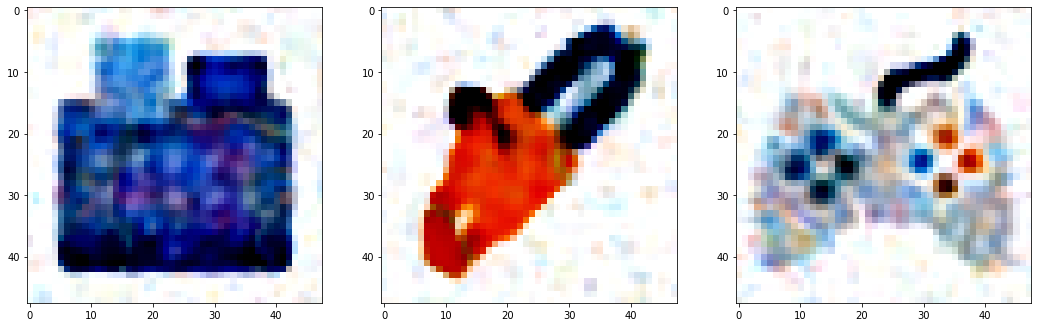

Step 200, Total loss 0.021168


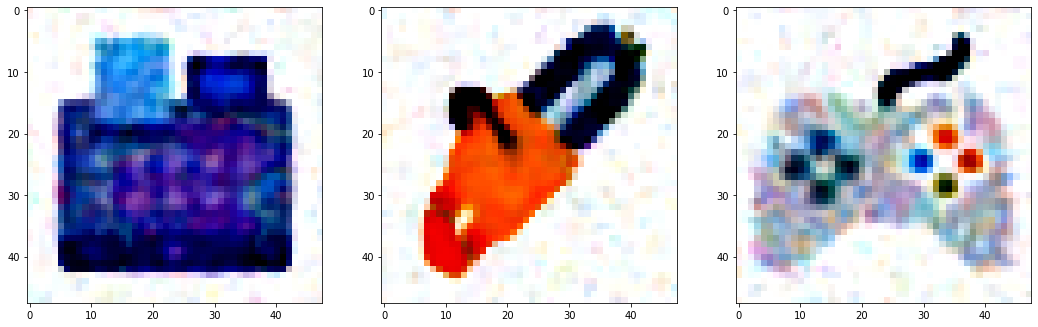

Step 250, Total loss 0.013978


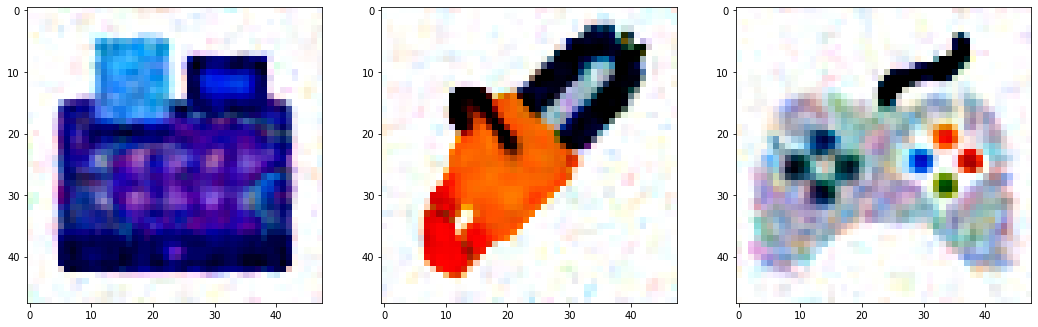

Step 300, Total loss 0.009930


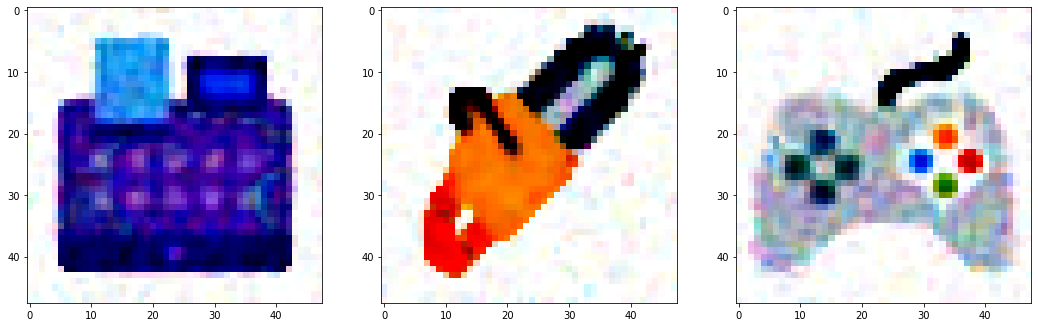

Step 350, Total loss 0.007722


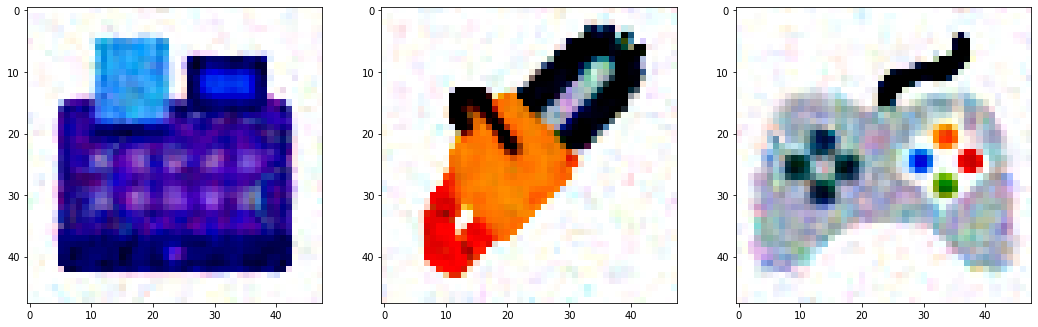

Step 400, Total loss 0.006289


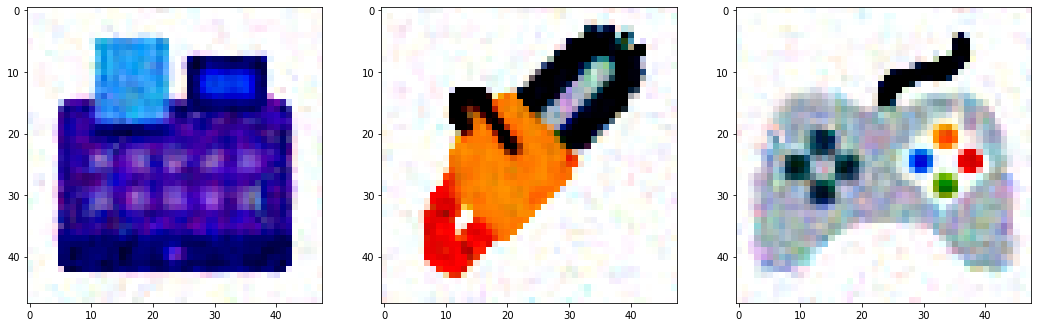

Step 450, Total loss 0.005293


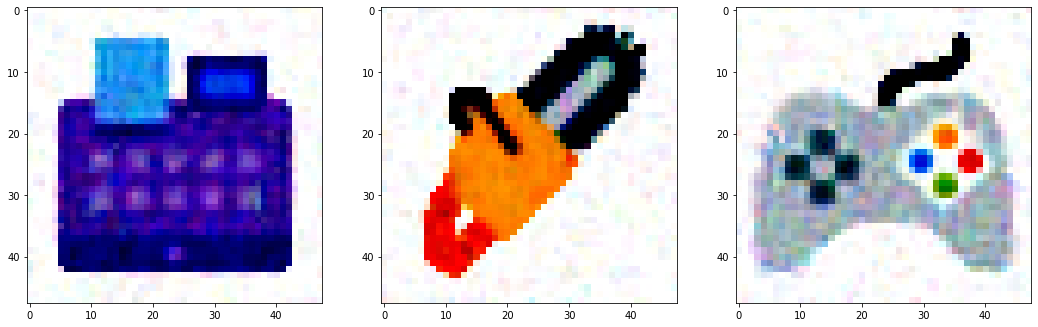

Step 500, Total loss 0.004547


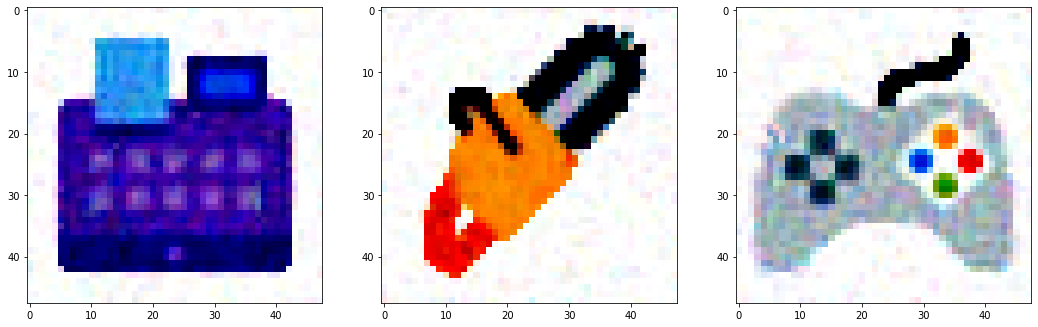

In [ ]:
total_steps = 501 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)    
    loss = ((torch.flatten(model_output) - torch.flatten(ground_truth))**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output[:, :(48**2), :], coords)
        # img_laplacian = laplace(model_output[:, :(48**2), :], coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output[:, (13*48*48):(14*48*48),:].cpu().view(48,48,3).detach().numpy())
        axes[1].imshow(model_output[:, (15*48*48):(16*48*48),:].cpu().view(48,48,3).detach().numpy())
        axes[2].imshow(model_output[:, (19*48*48):(20*48*48),:].cpu().view(48,48,3).detach().numpy())
        # axes[1].imshow(img_grad[:, :(48**2)].norm(dim=-1).cpu().view(48,48).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(48,48).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

Generalization

In [ ]:
img_dataset_sampled = ImageFitting(48, num_samples_per_image=int(0.3 * 48**2))
dataloader_sampled = DataLoader(img_dataset_sampled, batch_size=1, pin_memory=True, num_workers=0)

img_siren_sampled = Siren(in_features=3, out_features=3, hidden_features=256,
                          hidden_layers=3, outermost_linear=True)
img_siren_sampled.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

Step 0, Total loss 0.002040


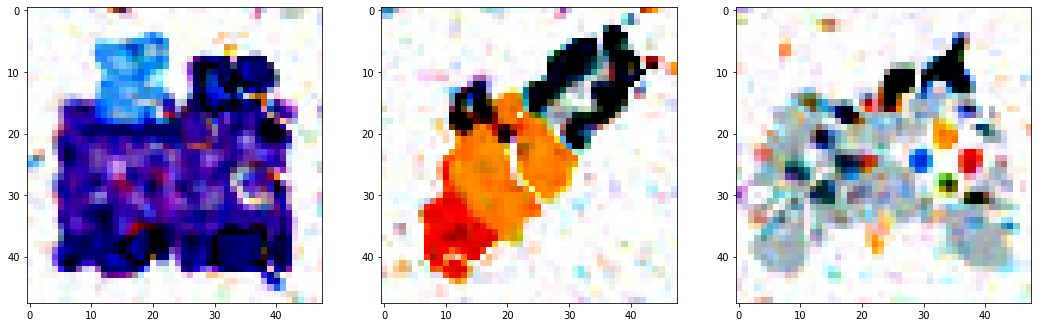

Step 50, Total loss 0.003364


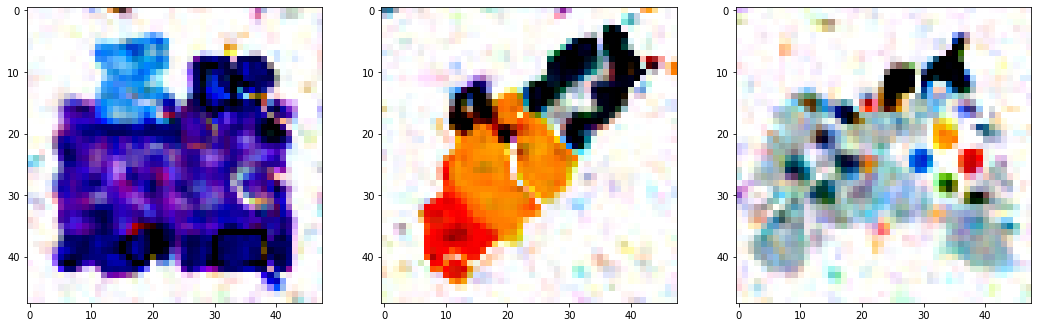

Step 100, Total loss 0.001985


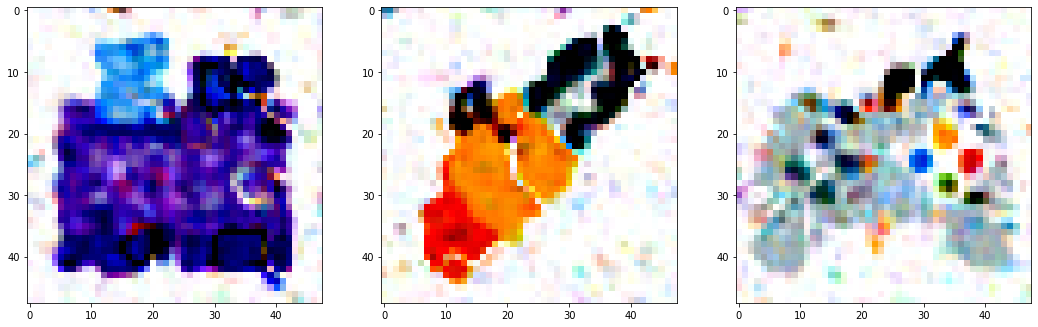

Step 150, Total loss 0.001688


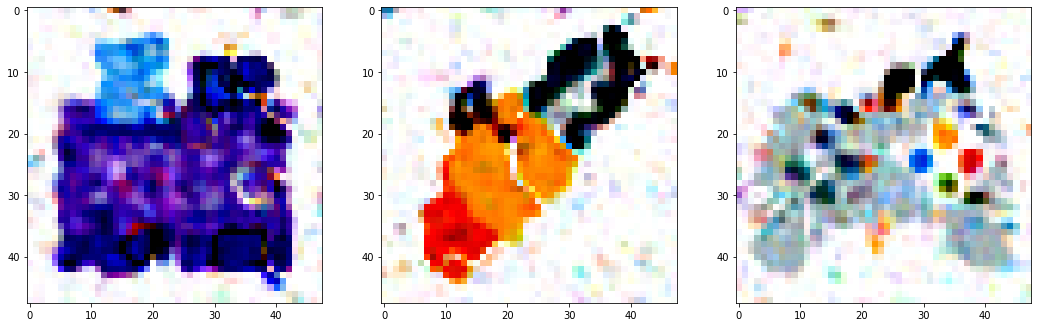

Step 200, Total loss 0.001511


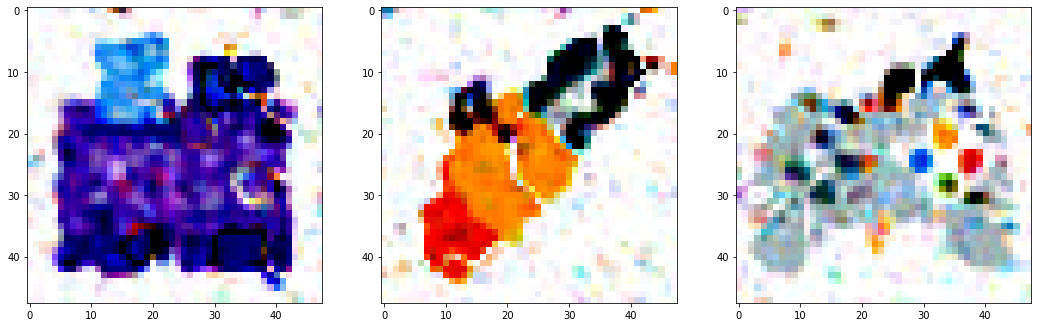

Step 250, Total loss 0.001372


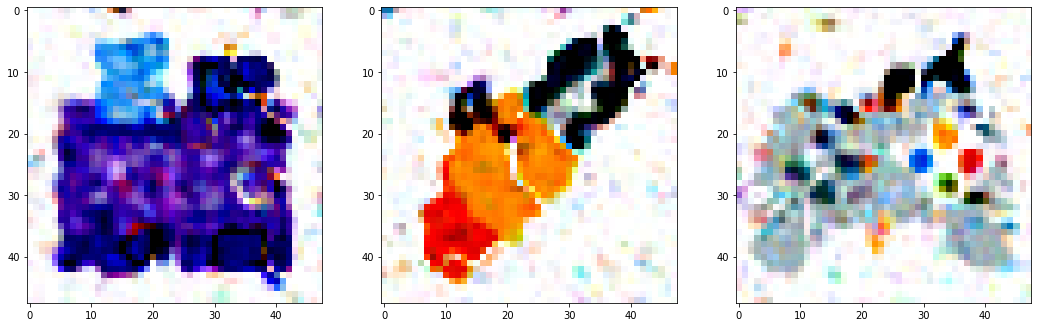

Step 300, Total loss 0.001251


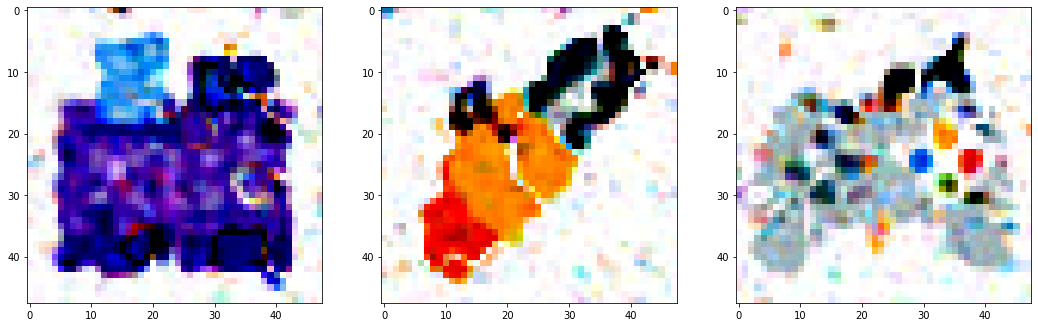

Step 350, Total loss 0.001143


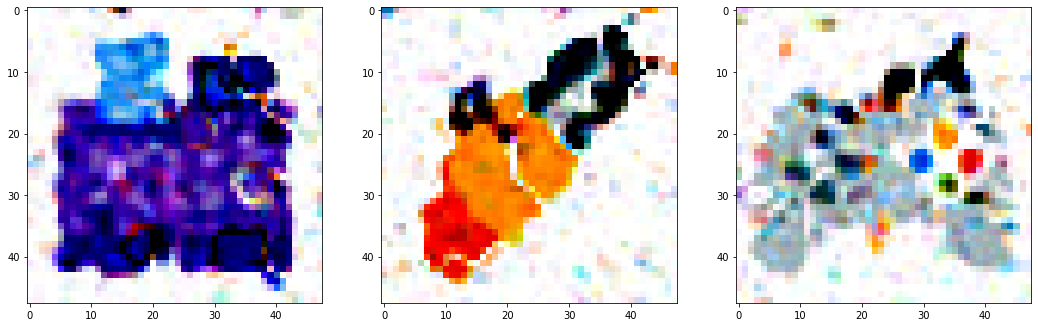

Step 400, Total loss 0.001045


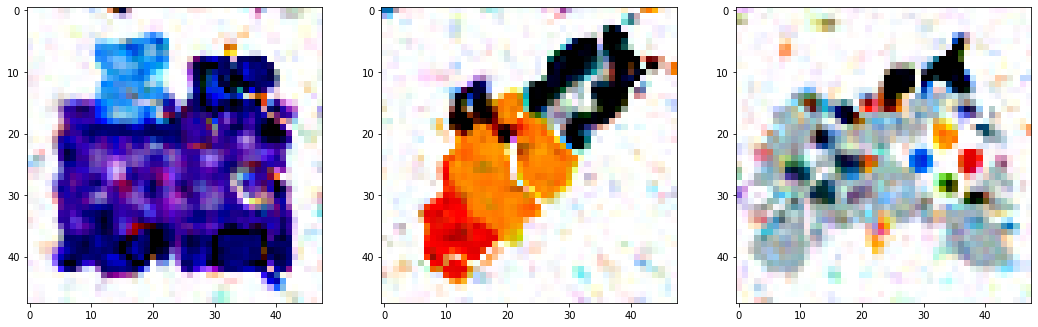

Step 450, Total loss 0.000957


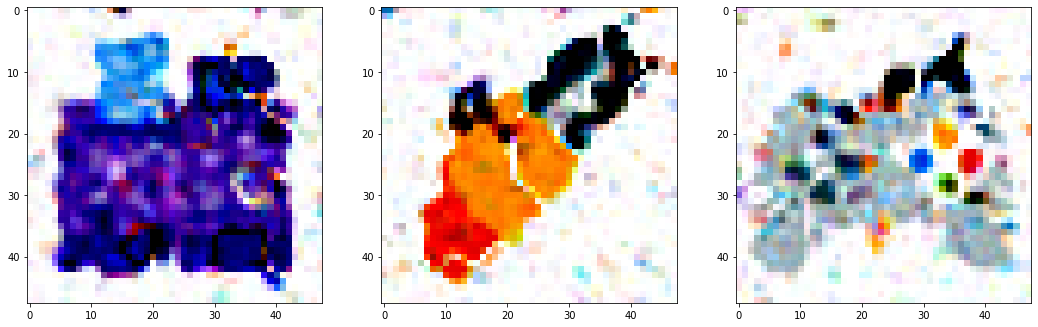

Step 500, Total loss 0.000878


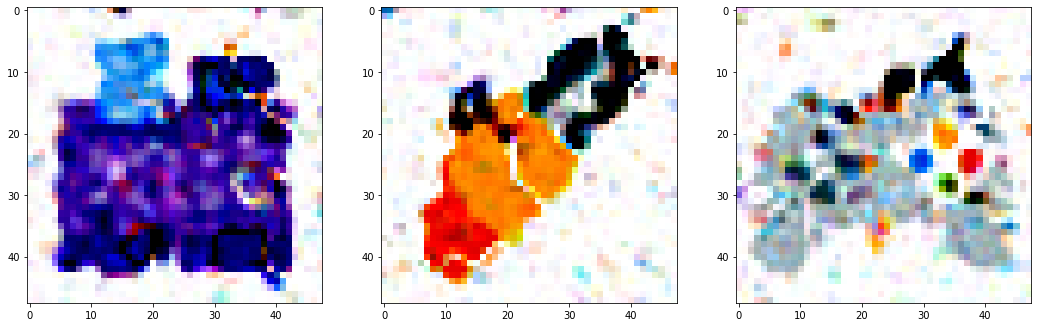

Step 550, Total loss 0.000806


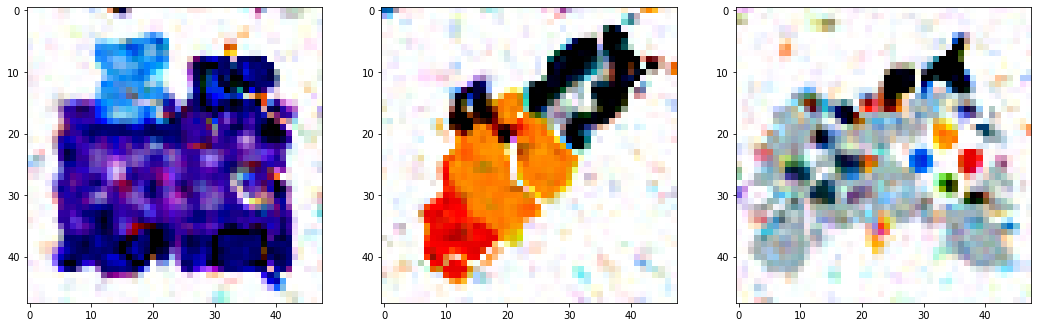

Step 600, Total loss 0.000742


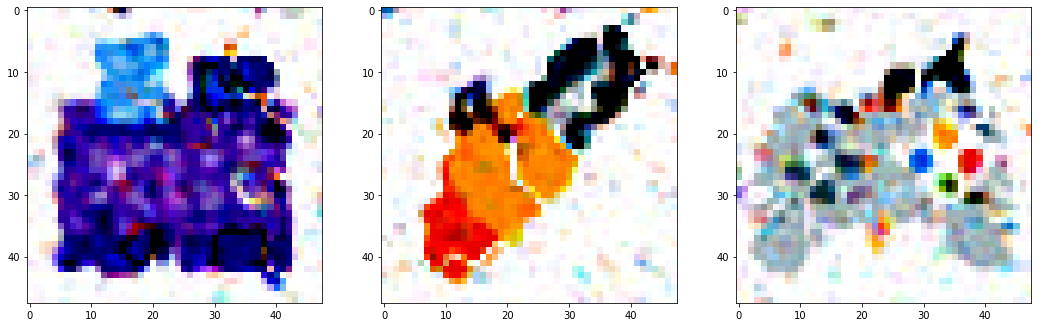

Step 650, Total loss 0.000691


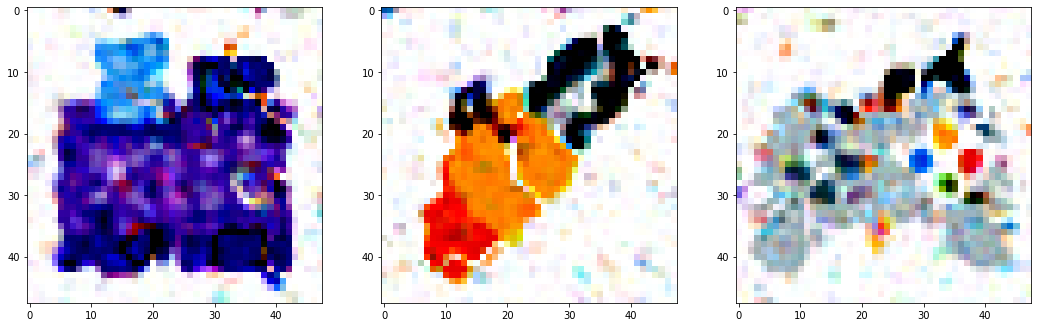

Step 700, Total loss 0.000667


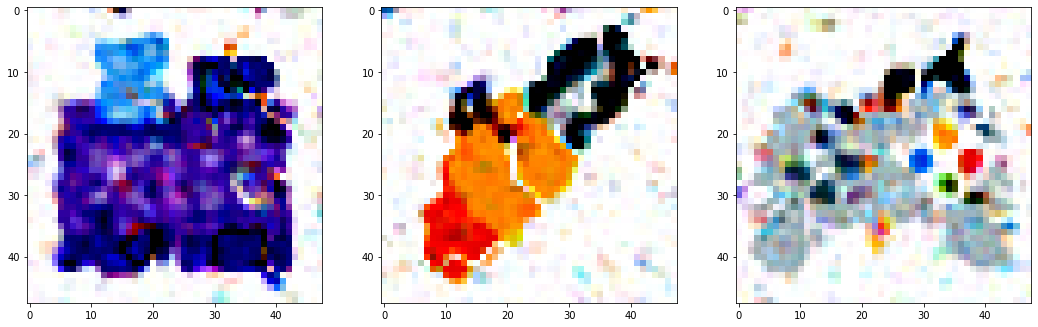

Step 750, Total loss 0.000594


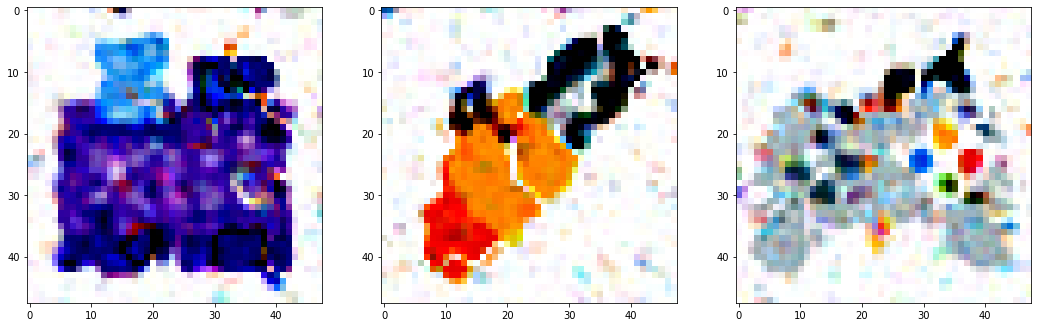

Step 800, Total loss 0.000547


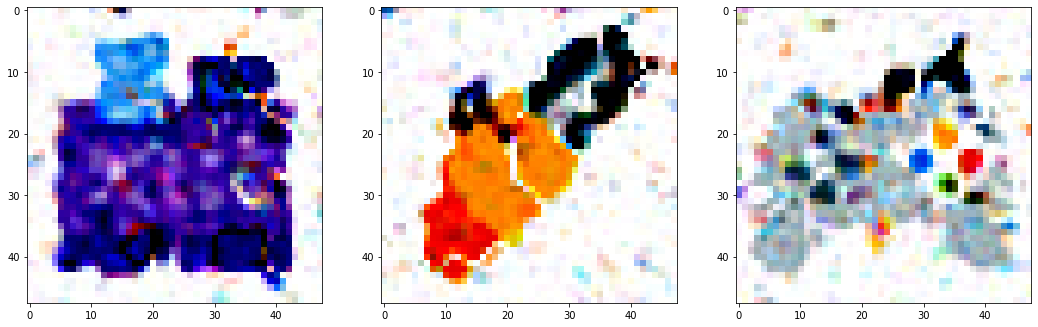

Step 850, Total loss 0.000506


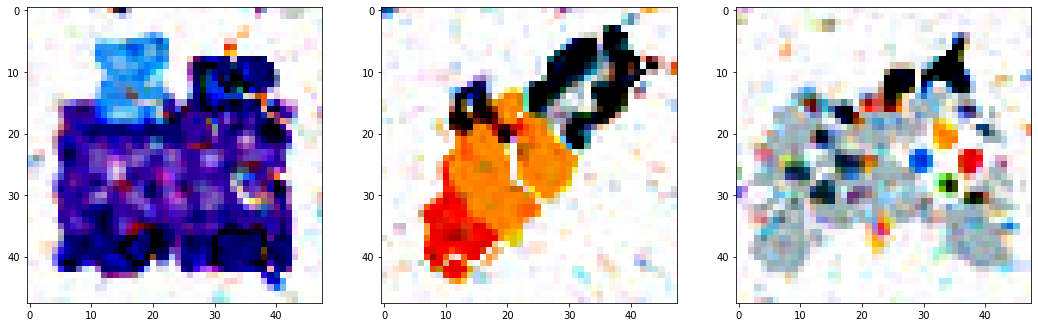

Step 900, Total loss 0.000480


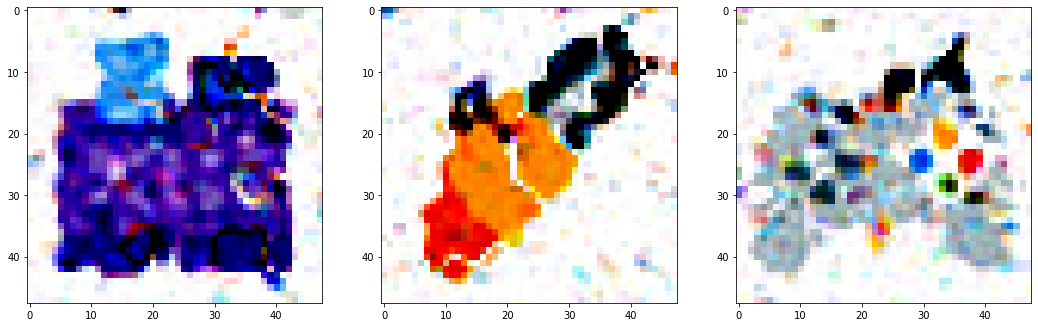

Step 950, Total loss 0.000475


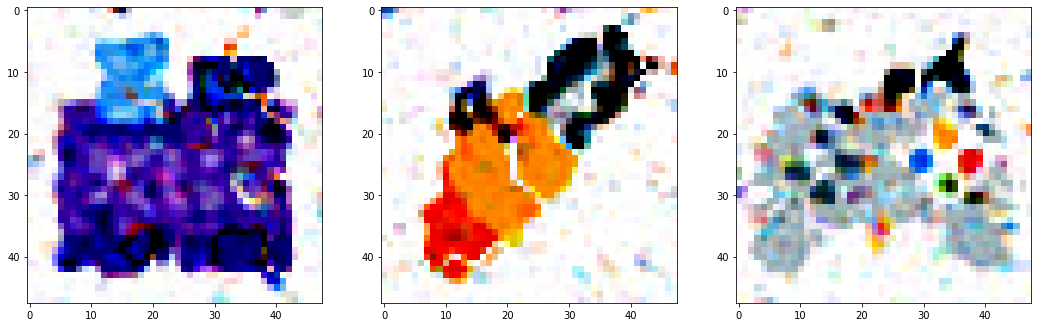

Step 1000, Total loss 0.000491


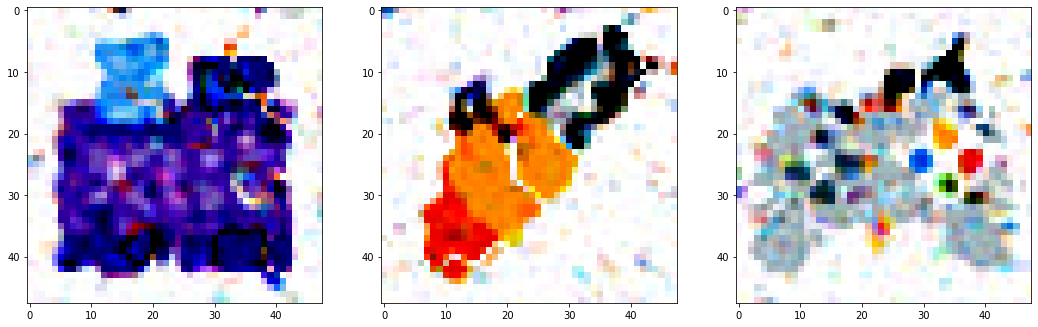

In [ ]:
total_steps = 1001
steps_til_summary = 50

optim_s = torch.optim.Adam(lr=1e-4, params=img_siren_sampled.parameters())

model_input_sampled, ground_truth_sampled = next(iter(dataloader_sampled))
model_input_sampled, ground_truth_sampled = model_input_sampled.cuda(), ground_truth_sampled.cuda()

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output_sampled, coords_sampled = img_siren_sampled(model_input_sampled)    
    loss = ((torch.flatten(model_output_sampled) - torch.flatten(ground_truth_sampled))**2).mean()
    # model_output, coords = img_siren_sampled(model_input)    
    # loss = ((torch.flatten(model_output) - torch.flatten(ground_truth))**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output[:, :(48**2), :], coords)
        # img_laplacian = laplace(model_output[:, :(48**2), :], coords)

        with torch.no_grad():
            model_output, coords = img_siren_sampled(model_input)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output[:, (13*48*48):(14*48*48),:].cpu().view(48,48,3).detach().numpy())
        axes[1].imshow(model_output[:, (15*48*48):(16*48*48),:].cpu().view(48,48,3).detach().numpy())
        axes[2].imshow(model_output[:, (19*48*48):(20*48*48),:].cpu().view(48,48,3).detach().numpy())
        # axes[1].imshow(img_grad[:, :(48**2)].norm(dim=-1).cpu().view(48,48).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(48,48).detach().numpy())
        plt.show()

    optim_s.zero_grad()
    loss.backward()
    optim_s.step()

Question 2(a): Image upsampling

Image 92, Total loss 0.002816


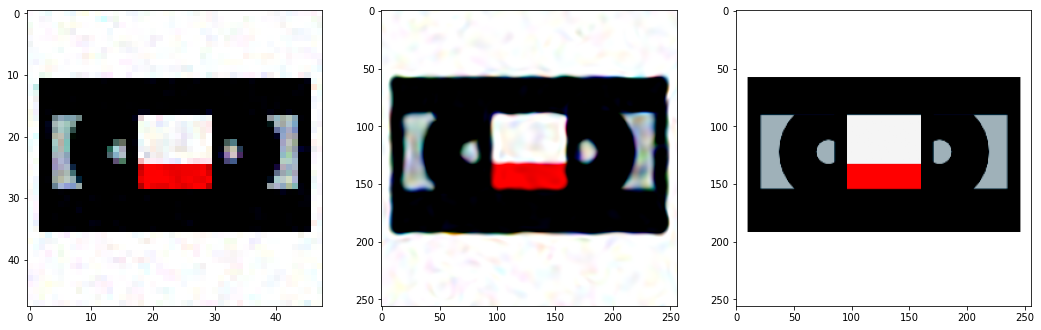

Image 7, Total loss 0.002816


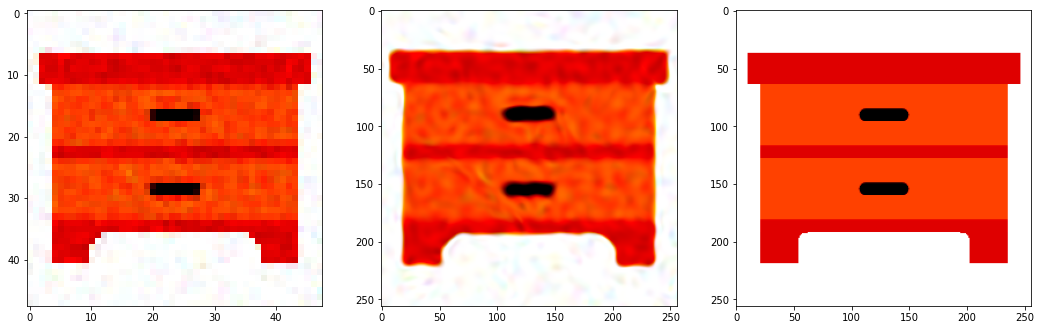

Image 3, Total loss 0.002816


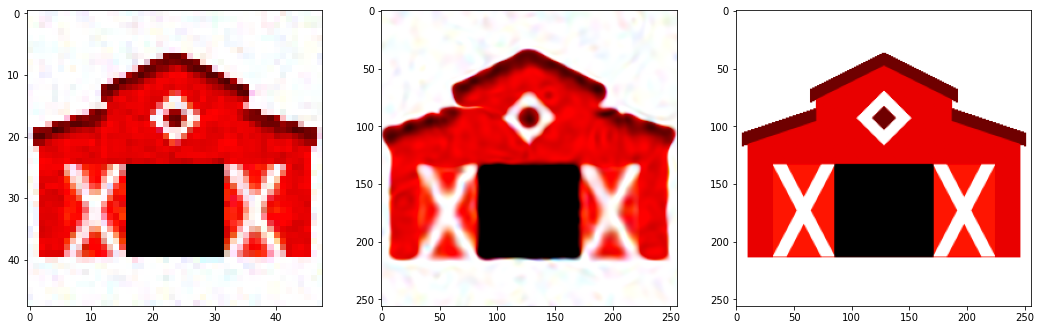

In [ ]:
for single_img_idx in [92, 7, 3]:

    img_dataset_large = ImageFitting(256, in_folder='/dev/ee_data_256', idx=single_img_idx)
    dataloader_large = DataLoader(img_dataset_large, batch_size=1, pin_memory=True, num_workers=0)

    model_input_large, ground_truth_large = next(iter(dataloader_large))
    model_input_large, ground_truth_large = model_input_large.cuda(), ground_truth_large.cuda()

    model_output_large, coords_large = img_siren(model_input_large)    
    loss = ((torch.flatten(model_output) - torch.flatten(ground_truth))**2).mean()
        
    print("Image %d, Total loss %0.6f" % (single_img_idx, loss))

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow(model_output[:, (single_img_idx*48*48):((single_img_idx+1)*48*48),:].cpu().view(48,48,3).detach().numpy())
    axes[1].imshow(model_output_large.cpu().view(256,256,3).detach().numpy())
    axes[2].imshow(ground_truth_large.cpu().view(256,256,3).detach().numpy())
    plt.show()




2(b): Interpolation

In [165]:
ind_a = 99
ind_b = 18

img_dataset_a = ImageFitting(256, in_folder='/dev/ee_data_256', idx=ind_a)
dataloader_a = DataLoader(img_dataset_a, batch_size=1, pin_memory=True, num_workers=0)

img_dataset_b = ImageFitting(256, in_folder='/dev/ee_data_256', idx=ind_b)
dataloader_b = DataLoader(img_dataset_b, batch_size=1, pin_memory=True, num_workers=0)

img_siren_mix = Siren(in_features=2, out_features=3, hidden_features=256,
                      hidden_layers=3, outermost_linear=True)
img_siren_mix.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

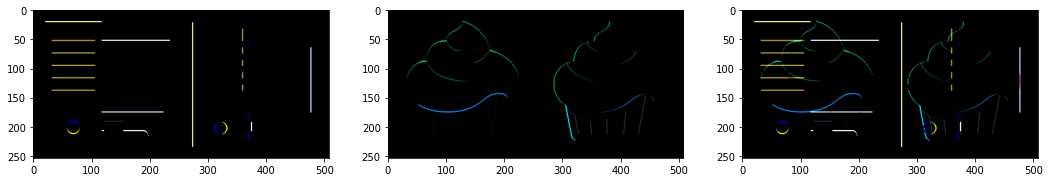

Step 0, Total loss 0.000298


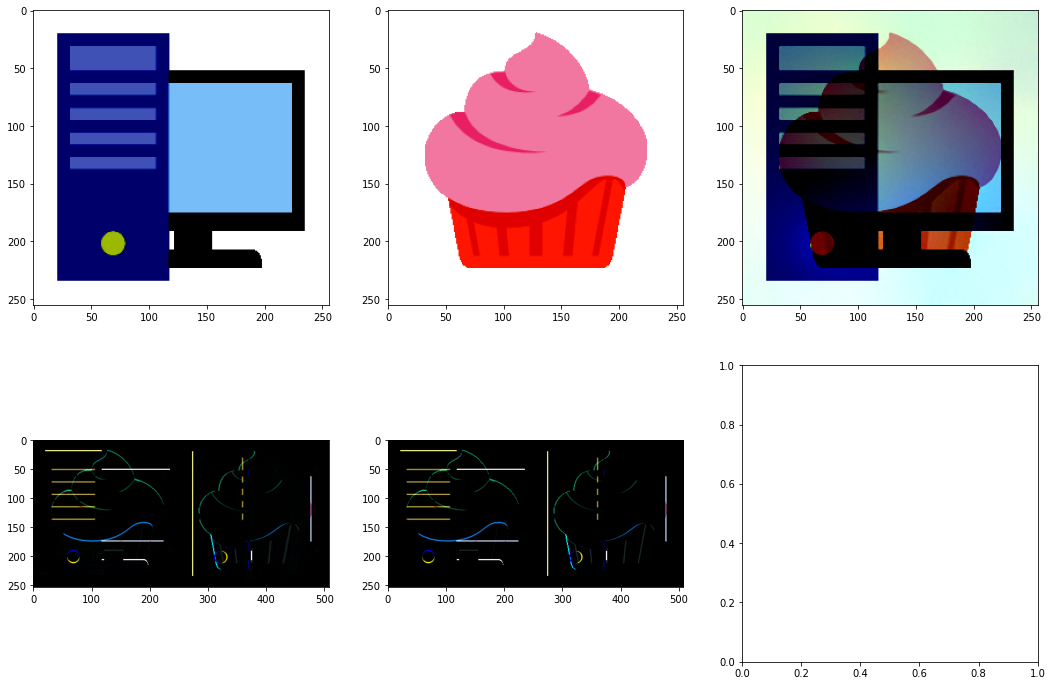

Step 200, Total loss 0.000196


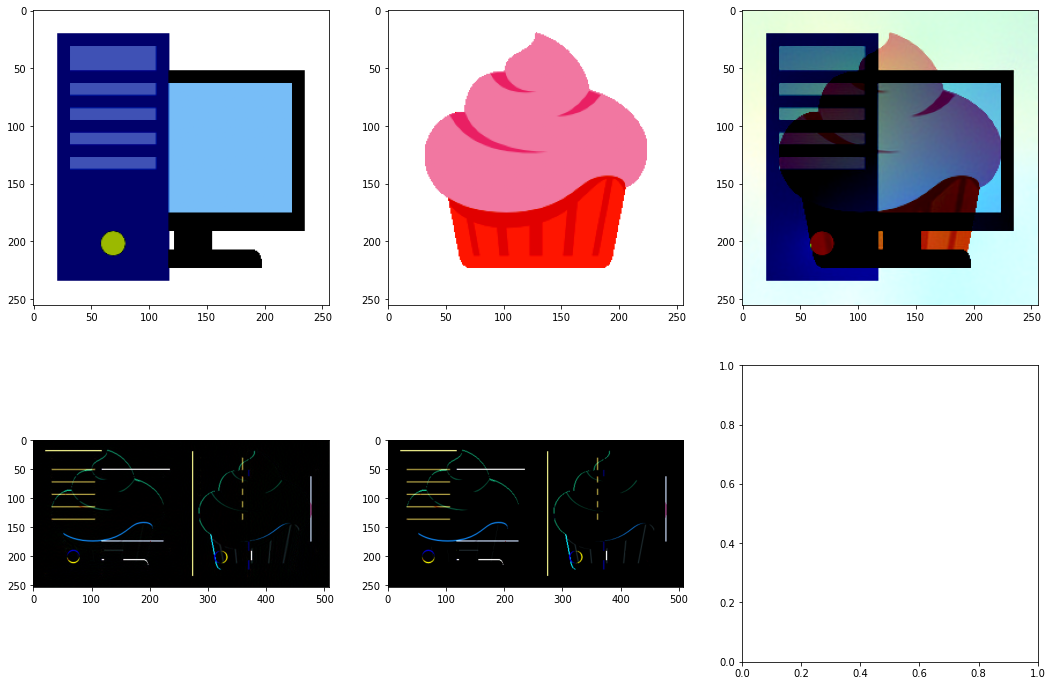

Step 400, Total loss 0.000099


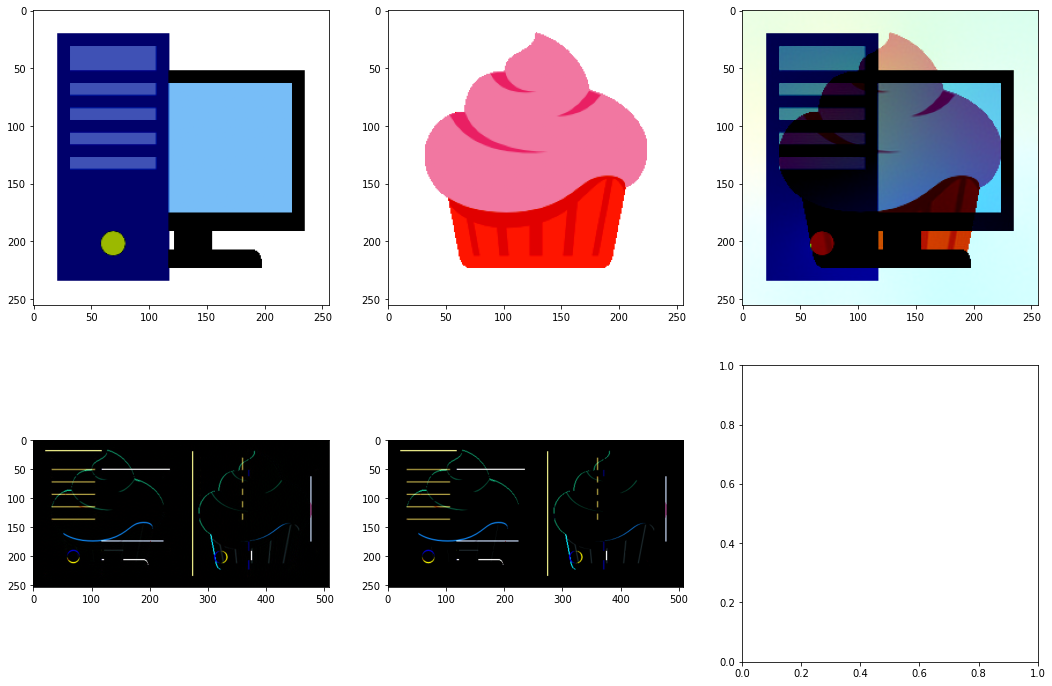

Step 600, Total loss 0.000069


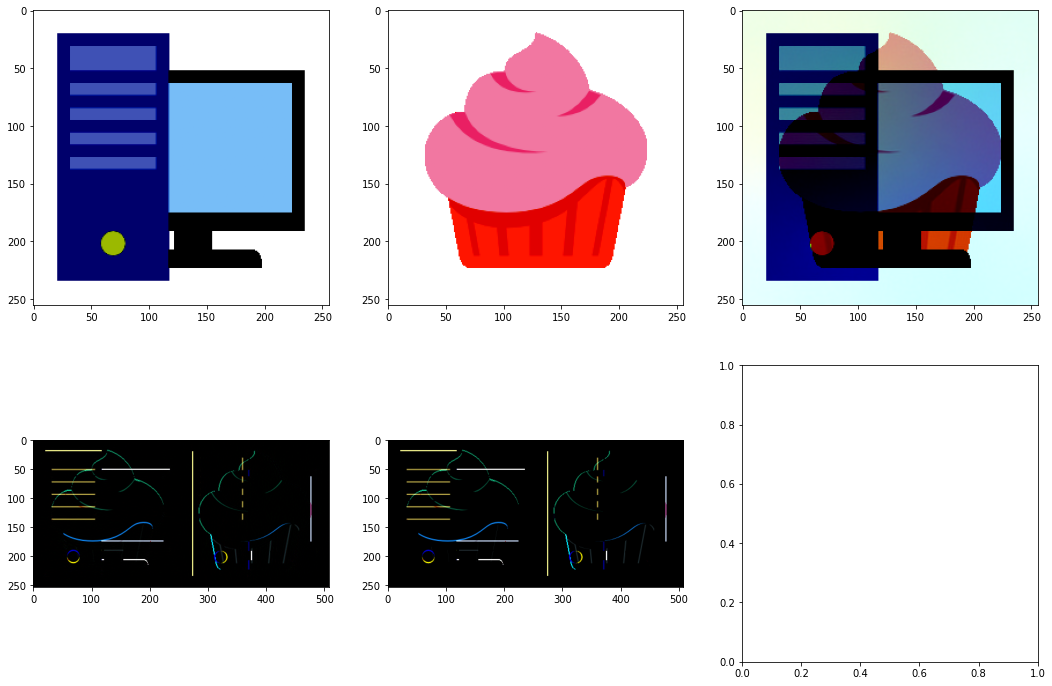

Step 800, Total loss 0.000283


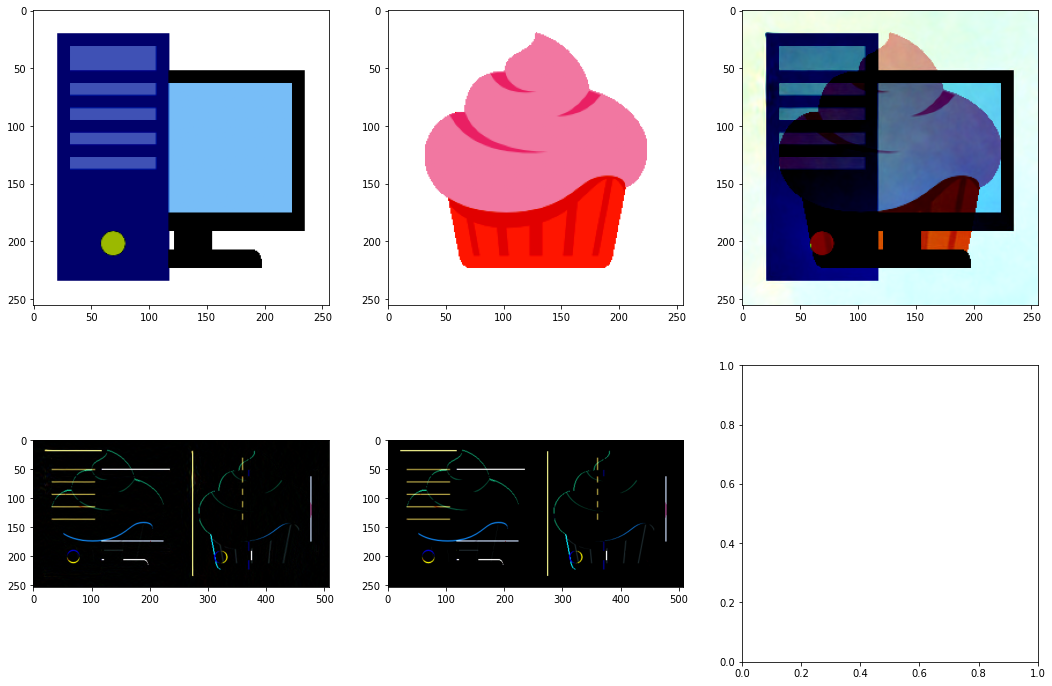

Step 1000, Total loss 0.000039


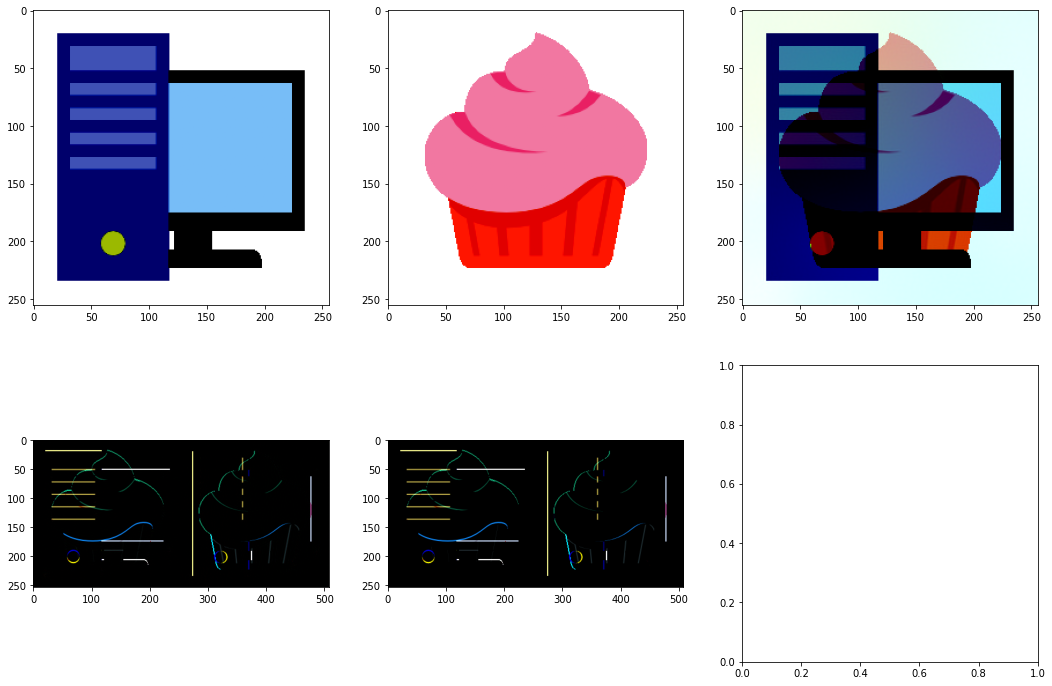

In [167]:
total_steps = 1001 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 200

optim = torch.optim.Adam(lr=1e-4, params=img_siren_mix.parameters())

model_input_a, ground_truth_a = next(iter(dataloader_a))
model_input_a, ground_truth_a = model_input_a.cuda(), ground_truth_a.cuda()

model_input_b, ground_truth_b = next(iter(dataloader_b))
model_input_b, ground_truth_b = model_input_b.cuda(), ground_truth_b.cuda()

def calc_grad(img):
    grad_img_x = img.view(256,256,3)[:-2, :-2, :] - img.view(256,256,3)[2:, :-2, :]
    grad_img_y = img.view(256,256,3)[:-2, :-2, :] - img.view(256,256,3)[:-2, 2:, :]
    grad_img = torch.hstack((grad_img_x, grad_img_y))
    return grad_img

grad_a = calc_grad(ground_truth_a)
grad_b = calc_grad(ground_truth_b)
grad_gt = grad_a + grad_b

fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(grad_a.cpu().detach().numpy())
axes[1].imshow(grad_b.cpu().detach().numpy())
axes[2].imshow(grad_gt.cpu().detach().numpy())
plt.show()

for step in range(total_steps):
    model_output_a, coords_a = img_siren_mix(model_input_a[:, :, :2])
    # model_output_b, coords_b = img_siren_mix(model_input_b)

    # print(model_output_a.shape)
    # print(coords_a.shape)    

    # img_grad_siren, img_laplace_siren = compute_grad_lap(torch.tensor(model_output_a))
    # img_grad_siren = gradient(model_output_a, coords_a)
    img_grad_siren = calc_grad(model_output_a)

    # print(img_grad_siren.shape)
    
    loss = ((torch.flatten(img_grad_siren) - torch.flatten(grad_gt))**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output[:, :(48**2), :], coords)
        # img_laplacian = laplace(model_output[:, :(48**2), :], coords)

        fig, axes = plt.subplots(2,3, figsize=(18,12))
        axes[1,0].imshow(img_grad_siren.view(254,254*2,3).cpu().detach().numpy())
        axes[1,1].imshow(grad_gt.view(254,254*2,3).cpu().detach().numpy())
        axes[0,0].imshow(ground_truth_a.view(256,256,3).cpu().detach().numpy())
        axes[0,1].imshow(ground_truth_b.view(256,256,3).cpu().detach().numpy())
        axes[0,2].imshow(model_output_a.view(256,256,3).cpu().detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()